In [1]:
import librosa.display
from glob import glob
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image
import json
import matplotlib.pyplot as plt

A script transforming the AudioMNIST-dataset (https://github.com/soerenab/AudioMNIST) into StyleGAN v3 compatible dataformat.

In [2]:
DIR = "AudioMNIST"
files = glob(DIR + "/**/*.wav", recursive=True)
n_fft = 2048
hop_length = 128

In [3]:
labels = []
shapes = []
for file in tqdm(files):
    signal, sr = librosa.load(file)  # Get signal and sample-rate
    
    """Generate MEL-Spectrogram and transform it to db."""
    mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, window="hann", hop_length=hop_length, n_fft=n_fft)
    spectrogram = np.abs(mel_signal)
    power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
    
    """Get class and file name elements."""
    file_name = file.split("/")[-1].split(".")[0]
    cl, sp, id = file_name.split("_")
    
    """Transform all images into shape 128x128. Pad if smaller, cut if too big."""
    h, w = mel_signal.shape
    shapes.append(w)  # To see the distribution
    assert h == 128, "Something went wrong mel spectrogram should always be 128xM"
    padding = ((0,0), (0, 128-w))  # Only pad on right.
    image_array = np.pad(power_to_db, padding) if w < 128 else power_to_db[:, :128]
    pil_image = Image.fromarray(image_array.astype("uint8"))
    
    """Save image and label map."""
    rel_path = f"transformed/{cl}_{sp}_{id}.png"
    save_path = f"{DIR}/{rel_path}"
    pil_image.save(save_path)
    labels.append([rel_path, int(cl)])

"""Save dataset map with labels.""" 
with open(f"{DIR}/dataset.json", "w") as f:
    elem = {"labels": labels}
    json.dump(elem, f)

  0%|          | 0/30000 [00:00<?, ?it/s]

### Visualize some Metrics

Average size: 111.21
Average padding size: 23.97
Average cutoff size: 12.45
Percentage of pads: 79.89%
Percentage of cutoffs: 18.92%


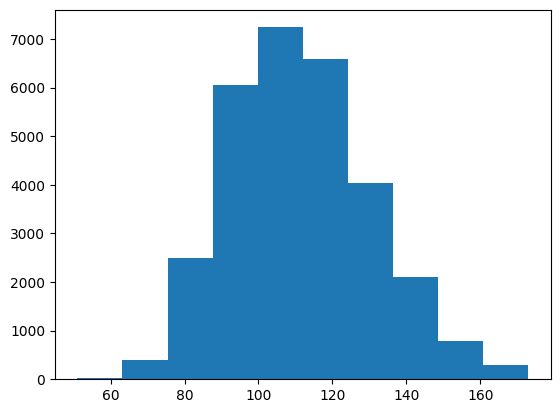

In [8]:
shapes = np.array(shapes)
plt.hist(shapes)
print(f"Average size: {np.mean(shapes):.2f}")
print(f"Average padding size: {np.abs(np.mean(shapes[shapes < 128]-128)):.2f}")
print(f"Average cutoff size: {np.mean(shapes[shapes > 128]-128):.2f}")
print(f"Percentage of pads: {len(shapes[shapes < 128])/len(shapes):.2%}")
print(f"Percentage of cutoffs: {len(shapes[shapes > 128])/len(shapes):.2%}")